## Group Project: Detecting AI generated text

Kaggle Competition Link: https://www.kaggle.com/competitions/llm-detect-ai-generated-text

Goal: Classify essays into AI-written text and Student-written text.

Tasks performed: 
1. Analysing the Data:
    - Remove punctuations
    - Analysing the length of essays
    - Comparing Essay Lengths
    - Analysis of most common words by student and LLM

2. Pre-processing the Data:
    - Removing Duplicate records
    - Creating a vocabulary index: Using the TextVectorization to index the vocabulary found in the dataset. Later, we use the same layer instance to vectorize the samples. Our layer will only consider the top 30,000 words, and will truncate or pad sequences to be actually 200 tokens long.

3. Embedding and Modelling:
    - Used pre-trained GLOVE Embeddings
    - Created the Embedding Matrix
    - Created tensorflow.keras.layers.Embedding layer and embedded the text sequences


4. Modelling

    Model Summary:

    - input_1 (InputLayer)     
    - embedding_1 (Embedding)
    - bidirectional (Bidirectional LSTM Layer)                                                             
    - dense (Dense)    
    - dense_1 (Dense)  
    - dropout (Dropout)       
    - dense_2 (Dense) 

4. Evaluation:
   - Validation Accuracy: 98.41%
   - Kaggle Submission Accuracy: 80.9%

## I. Analysing the Data

### Importing the Dataset

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import string
import sys
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
#from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast
from sklearn.linear_model import SGDClassifier

In [2]:
#Data given by Kaggle

train_prompt_file = "train_prompts.csv"
df_train_prompt = pd.read_csv(train_prompt_file)

train_essay_file = "train_essays.csv"
df_train_essay = pd.read_csv(train_essay_file)

test_essay_file = "test_essays.csv"
df_test_essay = pd.read_csv(test_essay_file)

sub_file = "sample_submission.csv"
df_sub = pd.read_csv(sub_file)

In [3]:
df_train_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
df_train_prompt.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
df_train_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [6]:
df_train_essay["generated"].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [7]:
## Since there is class imbalanced problem, we will use external dataset
train_essay_ex = "train_v2_drcat_02.csv"
df_train_essay_ex = pd.read_csv(train_essay_ex)
df_train_essay_ex.rename(columns = {"label":"generated"}, inplace=True)

## Merging datasets
df = pd.concat([df_train_essay_ex[["text", "generated"]],df_train_essay[["text", "generated"]]])
df['generated'].value_counts()



generated
0    28746
1    17500
Name: count, dtype: int64

In [8]:
df.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [9]:
df_test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


Since the test data from kaggle is a dummy data, we will validate our results on using train test split in our dataframe

### Analyzing the Texts

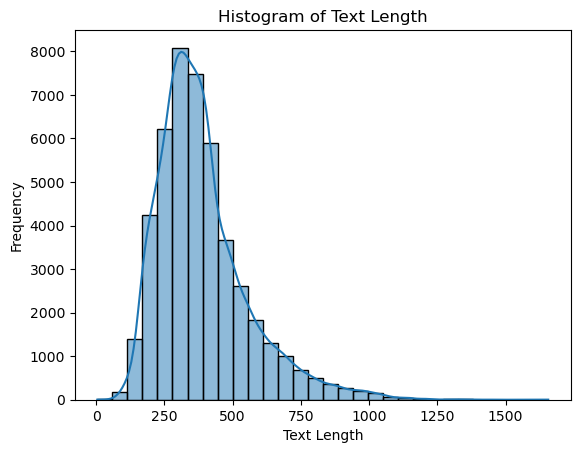

In [10]:
#Length of essays
df["text_len"] = df["text"].apply(lambda x : len(x.split()))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
df["text_len"].describe()

count    46246.000000
mean       388.761428
std        167.367549
min          4.000000
25%        276.000000
50%        357.000000
75%        461.000000
max       1656.000000
Name: text_len, dtype: float64

In [12]:
#Count for unique words
unique_words = set()
for text in df['text']:
    words = text.lower().split()  # Convert to lowercase and split into words
    unique_words.update(words)

# Remove punctuation from each word
unique_words = {word.strip(string.punctuation) for word in unique_words}

# Now, unique_words set contains all unique words
total_unique_words = len(unique_words)
print("Total unique words:", total_unique_words)

Total unique words: 99072


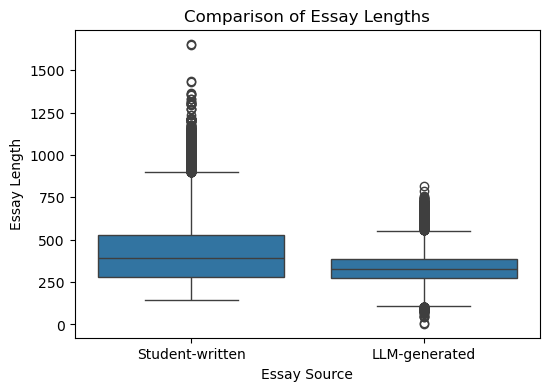

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x='generated', y='text_len', data=df)
plt.title('Comparison of Essay Lengths')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

### Analysis of most common words by student and LLM

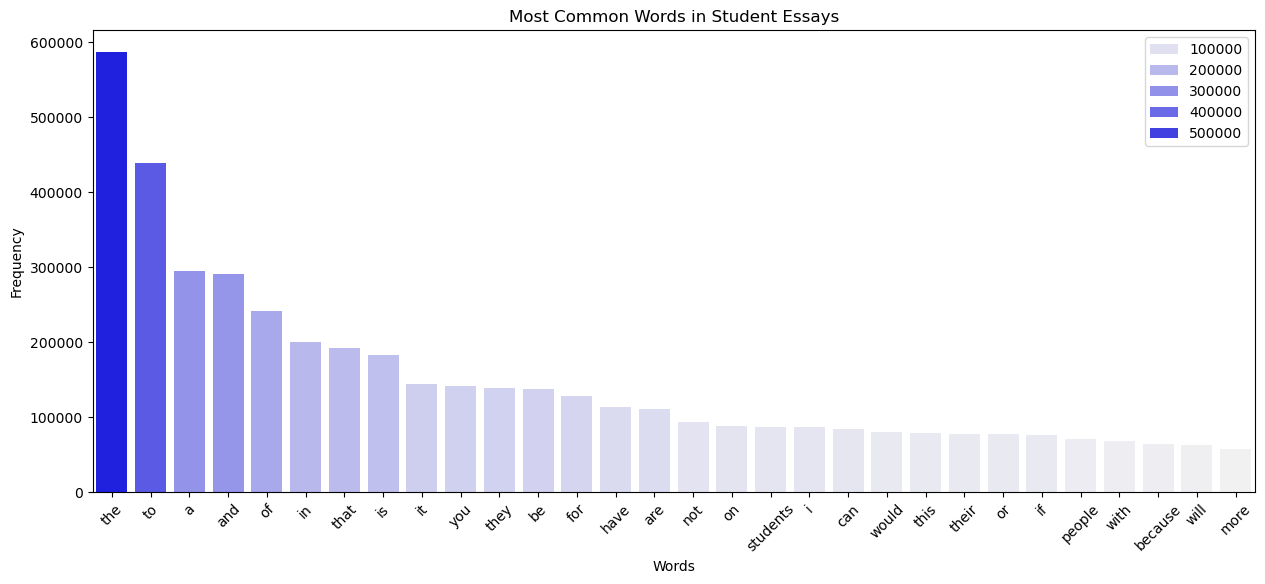

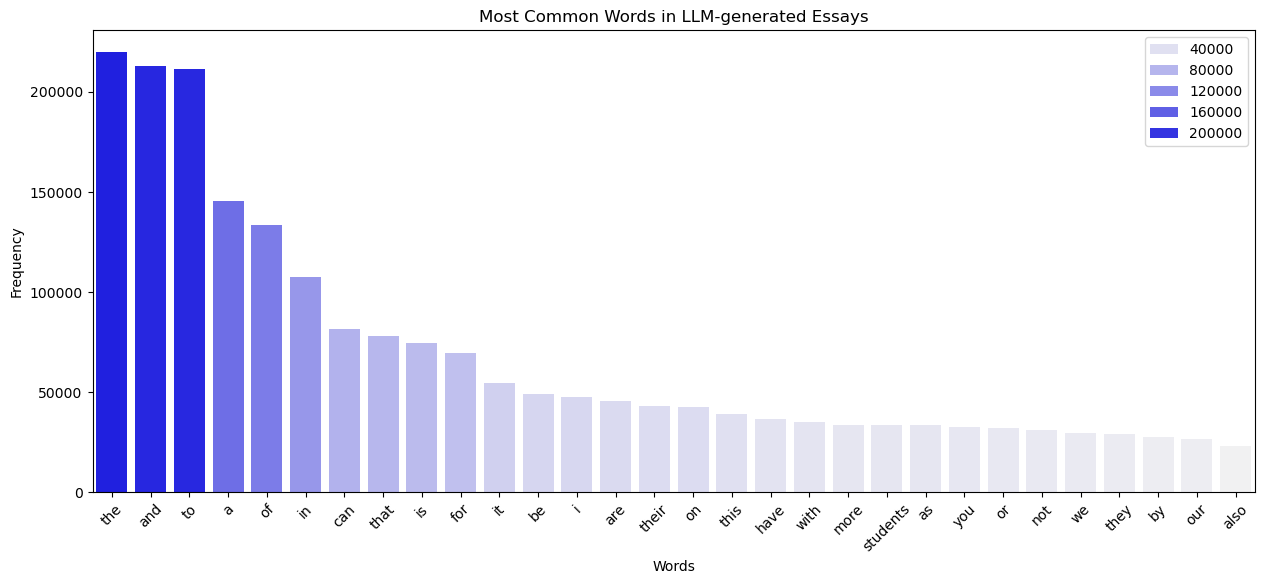

In [14]:
from collections import Counter
import itertools

def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    
    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words],hue=[freq for word, freq in common_words],palette='light:blue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_most_common_words(df[df['generated'] == 0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(df[df['generated'] == 1]['text'], title="Most Common Words in LLM-generated Essays")

In [15]:
df

,text,generated,text_len
0,Phones\n\nModern humans today are always on th...,0,379
1,This essay will explain if drivers should or s...,0,366
2,Driving while the use of cellular devices\n\nT...,0,178
3,Phones & Driving\n\nDrivers should not be able...,0,212
4,Cell Phone Operation While Driving\n\nThe abil...,0,332
...,...,...,...
1373,There has been a fuss about the Elector Colleg...,0,430
1374,Limiting car usage has many advantages. Such a...,0,397
1375,There's a new trend that has been developing f...,0,749
1376,As we all know cars are a big part of our soci...,0,525


## II. Data Pre-processing

#### 1) Removing Duplicate records

In [16]:
df.drop_duplicates(subset=['text'],inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop('text_len',inplace=True ,axis=1 )

#### 2) Train test split

In [17]:
## train_test_Split
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['generated'], test_size=0.33, random_state=42)

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (30061,)
y_train shape:  (30061,)
X_test shape:  (14807,)
y_test shape:  (14807,)


#### 3) Creating a vocabulary index

In [22]:
#Using the TextVectorization to index the vocabulary found in the dataset. 
#Later, we'll use the same layer instance to vectorize the samples.
#Our layer will only consider the top 30,000 words, and will truncate or pad sequences 
#to be actually 200 tokens long.

vectorizer = TextVectorization(max_tokens=30000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2024-01-19 16:04:53.275354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [23]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'in', 'that', 'is']

In [24]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

## III. Embedding & Modelling

### Load pre-trained Glove word embeddings

In [25]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/Users/dibyanshu/Documents/Jupyter Codes/NLP/Movie Classifier/glove.6B/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


### Creating Embedding Matrix

In [26]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 20426 words (9574 misses)


### Creating Embedding Layer

In [28]:
from tensorflow.keras.layers import Embedding
import keras
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

## IV. Modelling

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional


# Creating model
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(LSTM(100))(embedded_sequences)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, preds)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 200)         6000400   
                                                                 
 bidirectional (Bidirection  (None, 200)               240800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

In [30]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_val = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_test)

### Fitting the Model

In [31]:
model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5


2024-01-19 16:12:24.682040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:12:24.864243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:12:24.875307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:12:25.141623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:12:25.156087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.2737 - acc: 0.8882

2024-01-19 16:12:48.864895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:12:48.930037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:12:48.938149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 29s 116ms/step - loss: 0.2737 - acc: 0.8882 - val_loss: 0.0894 - val_acc: 0.9689
Epoch 2/5
235/235 [==============================] - 26s 111ms/step - loss: 0.0864 - acc: 0.9717 - val_loss: 0.0470 - val_acc: 0.9848
Epoch 3/5
235/235 [==============================] - 26s 109ms/step - loss: 0.0429 - acc: 0.9865 - val_loss: 0.0435 - val_acc: 0.9868
Epoch 4/5
235/235 [==============================] - 25s 108ms/step - loss: 0.0255 - acc: 0.9921 - val_loss: 0.0327 - val_acc: 0.9901
Epoch 5/5
235/235 [==============================] - 29s 122ms/step - loss: 0.0131 - acc: 0.9962 - val_loss: 0.0690 - val_acc: 0.9841


In [32]:
y_pred= model.predict(x_val)

2024-01-19 16:15:56.444228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:15:56.499720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-19 16:15:56.516145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


463/463 [==============================] - 9s 18ms/step


In [33]:
y_pred

array([[9.9999976e-01],
       [3.8723542e-07],
       [9.9999964e-01],
       ...,
       [6.7609733e-08],
       [3.6313459e-06],
       [9.9887508e-01]], dtype=float32)

In [34]:
y_pred_labels = [round(y_pred[i][0]) for i in range(0,len(y_pred))]

## V. Evaluation: Preparing Output For Kaggle

In [35]:
df_test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [36]:
x_test = vectorizer(np.array([[s] for s in df_test_essay['text']])).numpy()

In [37]:
y_pred= model.predict(x_test)

1/1 [==============================] - 0s 86ms/step


In [38]:
y_pred

array([[0.97673917],
       [0.5001904 ],
       [0.5001904 ]], dtype=float32)

In [39]:
df_sub.drop('generated',axis=1,inplace= True)

In [40]:
df_sub['generated']=y_pred

In [41]:
df_sub.to_csv("Submission.csv")

In [42]:
y_pred = [9,3,4]
y_pred= np.array(y_pred)

In [43]:
type(y_pred)

numpy.ndarray

In [5]:
y_pred=pd.Series(y_pred.reshape(-1))

In [4]:
df_sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4
